In [25]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
from array2gif import write_gif

from models.vae import VAE

plt.style.use('ggplot')

mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


#### Instantiate VAE and Saver

In [2]:
vae = VAE(beta=1,batch_size=1000,learning_rate=1e-4,latent_dim=20)
saver = tf.train.Saver()

#### Training

In [3]:
# Initialization
list_of_latent_spaces = []
list_of_z_mu = []
history_loss = []
history_recon = []
history_kl = []
epoch_loss = 0
recon_loss = 0
kl_loss = 0

hm_epochs = 1000

In [10]:
for epoch in range(hm_epochs):

    for _ in range(int(mnist.train.num_examples/vae.batch_size)):
        epoch_x, epoch_label = mnist.train.next_batch(vae.batch_size)
        epoch_label = np.argmax(epoch_label,axis=1)
        _, c, recon, kl = vae.fit(np.rint(epoch_x).astype(np.float32))
        epoch_loss += c/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        recon_loss += recon/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        kl_loss += kl/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        history_loss.append(epoch_loss)
        history_recon.append(recon_loss)
        history_kl.append(kl_loss)
        
    if epoch % 10 is 0:
        print('Epoch', epoch+1, '/',hm_epochs,'; average loss:',epoch_loss, end='; ')
        print('Reconstruction loss : ', recon_loss, end='; ')
        print('KL loss', kl_loss)


Epoch 1 / 1000 ; average loss: 415.85677727272724; Reconstruction loss :  415.80114715909093; KL loss 0.055630555170232604
Epoch 11 / 1000 ; average loss: 2228.0055267045473; Reconstruction loss :  2224.71587869318; KL loss 3.2896487539117993
Epoch 21 / 1000 ; average loss: 3484.1059718749993; Reconstruction loss :  3477.4293836647744; KL loss 6.676591815879132
Epoch 31 / 1000 ; average loss: 4463.599648863635; Reconstruction loss :  4453.751180965912; KL loss 9.848469696183638
Epoch 41 / 1000 ; average loss: 5290.6236677556835; Reconstruction loss :  5277.618395170451; KL loss 13.005272782897965
Epoch 51 / 1000 ; average loss: 6040.615854403406; Reconstruction loss :  6024.322018323851; KL loss 16.293836768271735
Epoch 61 / 1000 ; average loss: 6742.254399431824; Reconstruction loss :  6722.50666576703; KL loss 19.74773441508904
Epoch 71 / 1000 ; average loss: 7407.507841619319; Reconstruction loss :  7384.239470454522; KL loss 23.26837342210252
Epoch 81 / 1000 ; average loss: 8043.48

Epoch 681 / 1000 ; average loss: 34328.49516136349; Reconstruction loss :  34163.805093821196; KL loss 164.69007059339964
Epoch 691 / 1000 ; average loss: 34703.5733880681; Reconstruction loss :  34537.04248607971; KL loss 166.53090482968324
Epoch 701 / 1000 ; average loss: 35077.69234957377; Reconstruction loss :  34909.325846733096; KL loss 168.36650486852406
Epoch 711 / 1000 ; average loss: 35450.86464424699; Reconstruction loss :  35280.668865270054; KL loss 170.1957815411645
Epoch 721 / 1000 ; average loss: 35823.12893409065; Reconstruction loss :  35651.11001072455; KL loss 172.0189262150147
Epoch 731 / 1000 ; average loss: 36194.47794318156; Reconstruction loss :  36020.641800284175; KL loss 173.8361453045921
Epoch 741 / 1000 ; average loss: 36564.94061455934; Reconstruction loss :  36389.291781179105; KL loss 175.64883473635456
Epoch 751 / 1000 ; average loss: 36934.52724240026; Reconstruction loss :  36757.071214204676; KL loss 177.4560289599322
Epoch 761 / 1000 ; average loss

#### Only use this section if saving model

In [11]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'saved_models/vae-fc-'
saved_filename = filename+timestr
saver.save(vae.sess,filename+timestr)

'saved_models/vae-fc-20181029-232545'

#### Restoring model weights

In [4]:
saver.restore(vae.sess, 'saved_models/vae-fc-20181029-232545')

INFO:tensorflow:Restoring parameters from saved_models/vae-fc-20181029-232545


#### Visualise data reconstruction

In [15]:
test_epoch, _ = mnist.test.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))

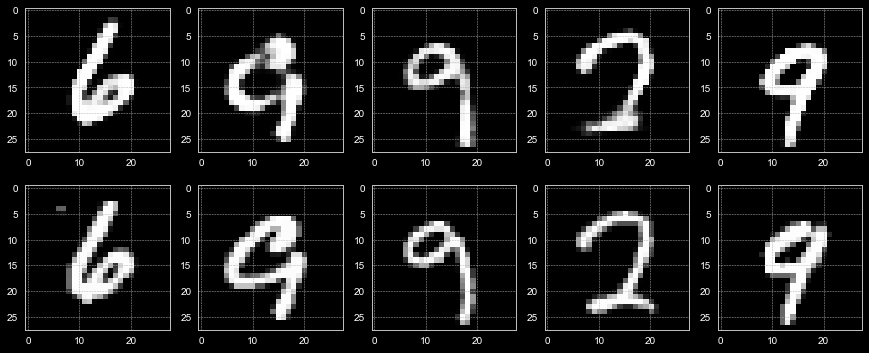

In [24]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()
n = 0
j = 0

for i in range(n,n+5):
    axs[j].imshow(x_tst[i,:].reshape([28,28]),cmap='gray')
    axs[j+5].imshow(test_epoch[i,:].reshape([28,28]),cmap='gray')
    j += 1
    
plt.show()

#### Visualise latent space

In [9]:
from sklearn import manifold

In [10]:
def draw_digits_latent_space(z_mean_test, test_label):
    plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
    plt.colorbar()
    plt.show()

In [13]:
test_x, test_label = mnist.train.next_batch(vae.batch_size)
test_label = np.argmax(test_label,axis=1)
z_mu = vae.get_z_mean(np.rint(test_x).astype(np.float32))
tsne = manifold.TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_mu)


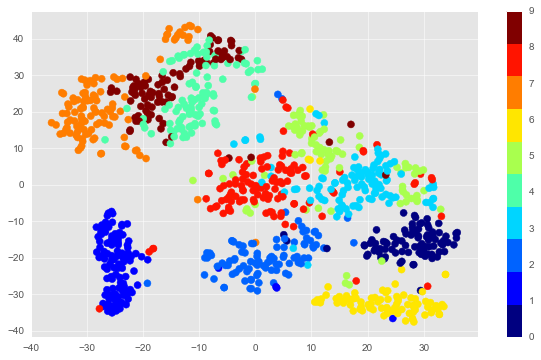

In [26]:
plt.figure(figsize=(10, 6))
draw_digits_latent_space(z_tsne, test_label)
plt.show()